In [1]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from collections import defaultdict
import seaborn as sns
from tqdm import tqdm 

import eye_metrics_utils
import data_utils
import gaze_entropy

# define ROIs

In [2]:
label = {"standby_ASI": [(534, 424), 50, "c"], # [(cx,cy), radius, type: "c" = circle]  
         "standby_AH": [(528,530), 50, "c"],
         "standby_ALT": [(523, 626), 45, "c"], 
         "RPM_LEFT": [(633, 411), (672, 451), "r"], #[(topleft_x,y), (bottomright_x,y), type: "r" = rectangle]  
         "G1000_ASI": [(674, 432), (705, 525), "r"],
         "G1000_AI": [(720, 413), (790, 495), "r"],
         "HSI": [(742, 556), 45, "c"],
         "G1000_ALT": [(797, 428), (852, 523), "r"],
         "NRST_Box": [(792, 534), (876, 554), "r"],
         "RPM_RIGHT": [(1054, 440), 30, "c"],
         "outside": [(0,0), (1280, 350), "r"]} 

In [3]:
label = {"outside": [(0,0), (1280, 350), "r"],
         "left_panel": [(480, 370), (580, 660), "r"],
         "ASI": [(600, 400), (705, 525), "r"],
         "ALT": [(790, 428), (876, 554), "r"],
         "HSI": [(742, 556), 45, "c"]
}

In [4]:
img = cv2.imread("flight.jpg")

overlay = img.copy()
thickness = -1

h,w,c = img.shape


In [5]:
pdict = defaultdict()
for key in label:
    if label[key][-1] == "c":
        mask = np.zeros((h,w), np.uint8)
        cv2.circle(mask,label[key][0], label[key][1],255,-1)
        points = np.where(mask==255)
        pdict[key] = points
    elif label[key][-1] == "r":
        mask = np.zeros((h,w), np.uint8)
        cv2.rectangle(mask,label[key][0], label[key][1],255,-1)
        points = np.where(mask==255)
        pdict[key] = points

In [6]:
color = (0,255,0)

for key in pdict:
    overlay[pdict[key]] = color

In [7]:
alpha = 0.6

# Following line overlays transparent rectangle over the image
image_new = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)

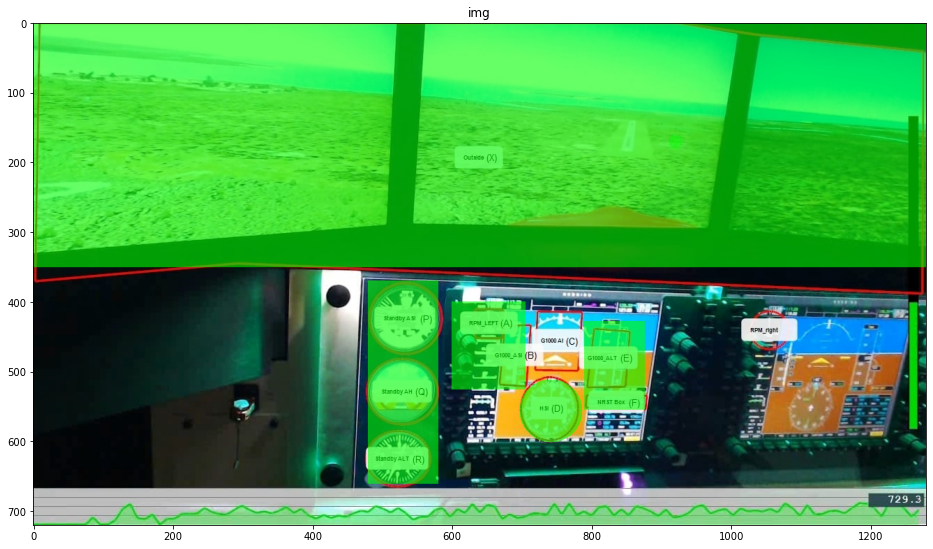

In [8]:
figure =plt.figure(figsize=(16,10))
plt.imshow(cv2.cvtColor(image_new, cv2.COLOR_BGR2RGB))
plt.title('img')
plt.show()

# get scanpath 

In [9]:
def dist_func(point, v1, v2, type="c"): #between points and rectange/cirle
    #point: x, y
    #v1,v2: topleft,bottomright if type = "r"
    #v1,v2: center (x,y),  if type = "c"
    d = 0
    if type == "r":
        dx = max(v1[0] - point[0], 0, point[0] - v2[0])
        dy = max(v1[1] - point[1], 0, point[1] - v2[1])
        
        d = np.sqrt(dx*dx + dy*dy)
    elif type == "c":
        d = np.sqrt((point[0]-v1[0])**2 + (point[1]-v1[1])**2) - v2
        
    return d

In [10]:
def offset(df_data, x_offset = - 15, y_offset = 15, x_name = "X Pos", y_name = "Y Pos"):
    df_x = df_data.copy()
    df_x[x_name] = df_x[x_name] + x_offset
    df_x[y_name] = df_x[y_name] + y_offset
    
    return df_x


In [45]:
csv_file = "data/PISSS_ID_002_Approach Two Gaze-Vergence.csv"

In [46]:
df_data = pd.read_csv(csv_file)

In [47]:
#df_data = df_data.dropna()

In [48]:
df_data = offset(df_data)

In [49]:
a, efix = get_scanpath(df_data)

In [50]:
df_efix = pd.DataFrame(efix, columns=["start", "stop", "duration", "x", "y", "roi"])
len(df_efix[df_efix["roi"] != "outside"]["duration"])

89

In [29]:
stt = [0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
df_stt = df_res[["par_id", "group"]]
df_stt["stt"] = stt
df_stt

NameError: name 'df_res' is not defined

NameError: name 'df_stt' is not defined

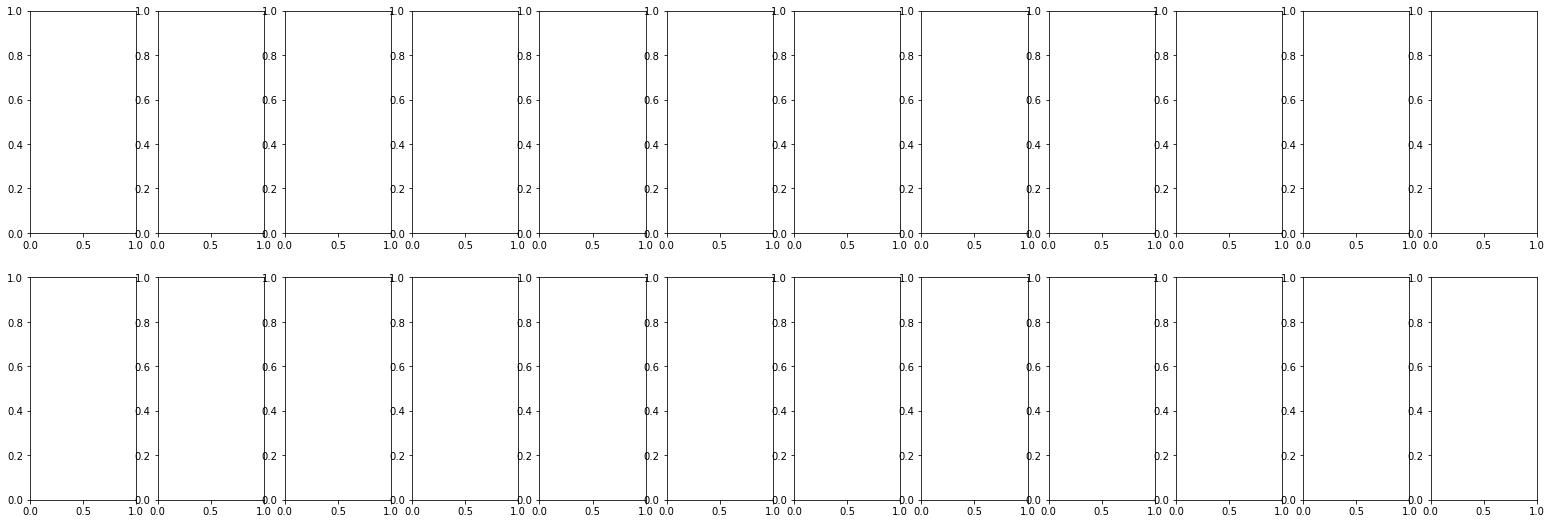

In [30]:
fig, axs = plt.subplots(2,12, figsize=(27,9))

for index, x in df_stt.iterrows():
    par_id = str(x["par_id"]).zfill(3)
    
    csv_file = "data/PISSS_ID_{}_Approach Two Gaze-Vergence.csv".format(par_id)
    df_data = pd.read_csv(csv_file)
    a, efix = get_scanpath(df_data)
    df_efix = pd.DataFrame(efix, columns=["start", "stop", "duration", "x", "y", "roi"])
    
    df_efix = df_efix[df_efix["roi"] == "outside"].reset_index()
    
    start = df_efix["start"] - df_efix["start"][0]
    diff = df_efix["start"].diff(20)
    trending = diff.rolling(window=20, center=True, min_periods=20).mean()
    
    ax = axs[x["group"] - 1, x["stt"]]
    ax.plot(start, diff)
    ax.set_ylim(0, 50)

#     ax.plot(trending)

    ax.set_title(par_id)
    
fig.text(0.5, 0.04, 'time (s)', ha='center')
fig.text(0.04, 0.5, 'time for 20 consecutive fixations (s)', va='center', rotation='vertical')

In [ ]:
fig, axs = plt.subplots(2,15, figsize=(27,9), sharey=True)
fig.suptitle("Change in fixation rate and fixation duration (out-the-window)", fontsize=16)

for index, x in df_stt.iterrows():
    par_id = str(x["par_id"]).zfill(3)
    
    csv_file = "data/PISSS_ID_{}_Approach Two Gaze-Vergence.csv".format(par_id)
    df_data = pd.read_csv(csv_file)
    a, efix = get_scanpath(df_data)
    df_efix = pd.DataFrame(efix, columns=["start", "stop", "duration", "x", "y", "roi"])
    
    df_efix = df_efix[df_efix["roi"] == "outside"].reset_index()
    
    start = df_efix["start"] - df_efix["start"][0]
    df_efix["start"] = start
    diff = df_efix["start"].diff(20)
    trending = diff.rolling(window=20, center=True, min_periods=20).mean()
    
    t = np.arange(0, int(np.ceil(start[len(start)-1])))
    fix_per_min = []
    change_fix_dur = []
    
    for i in range(0,t[-1] + 1):
        # fix rate
        if i >= 60:
            n = len(df_efix[(df_efix['start'] > i - 60) & (df_efix["start"] < i)])
        elif i < 60 and i > 10:
            n = len(df_efix[(df_efix['start'] > 0) & (df_efix["start"] < i )]) * 60 / i
        elif i <= 10:
            n = None
            
        # fix_dur
        if i >= 10:
            dur = df_efix[(df_efix['start'] > i - 10) & (df_efix["start"] < i)]["duration"].mean()
        elif i <10:
            dur = None
        
        change_fix_dur.append(dur)
        fix_per_min.append(n)
    
    ax = axs[x["group"] - 1, x["stt"]]
    ax.plot(t, fix_per_min, color="tab:blue")
    ax.set_ylim(0, 100)
    ax.tick_params(axis='y', labelcolor="tab:blue")
    
    ax2 = ax.twinx()
    ax2.plot(t, change_fix_dur, color = "tab:red")
    ax2.set_ylim(0, 12)
    ax2.tick_params(axis='y', labelcolor="tab:red")
    
    if x["group"] == 1 and x["stt"] != 9:
        ax2.tick_params(labelright=False)
    if x["group"] == 2 and x["stt"] != 14:
        ax2.tick_params(labelright=False)
    

#     ax.plot(trending)

    ax.set_title(par_id)
    
axs[0,0].set_ylabel('Group 1')
axs[1,0].set_ylabel('Group 2')
axs[0,10].set_axis_off()
axs[0,11].set_axis_off()
axs[0,12].set_axis_off()
axs[0,13].set_axis_off()
axs[0,14].set_axis_off()


fig.text(0.5, 0.04, 'time (s)', ha='center')
fig.text(0.07, 0.5, 'fixations per minute', color="tab:blue", va='center', rotation='vertical')
fig.text(0.93, 0.5, 'fixation duration (sec)', color='tab:red', va='center', rotation='vertical')

In [ ]:
merge_consecutive_fixations_in_same_roi(efix)

In [ ]:
encode(df_a["ROI"].values)

In [ ]:
create_transition_matrix(replace_repeated_character(encode(df_a["ROI"].values)))

In [31]:
cal_entropy(replace_repeated_character(encode(df_a["ROI"].values)))

NameError: name 'df_a' is not defined

In [74]:
# gaze_points = df_data[df_data["Start Time (secs)"] < Efix[n-1][1]].dropna()[["X Pos", "Y Pos"]].astype("int").values

In [80]:
df_efix.iloc[10,1]

639.152229

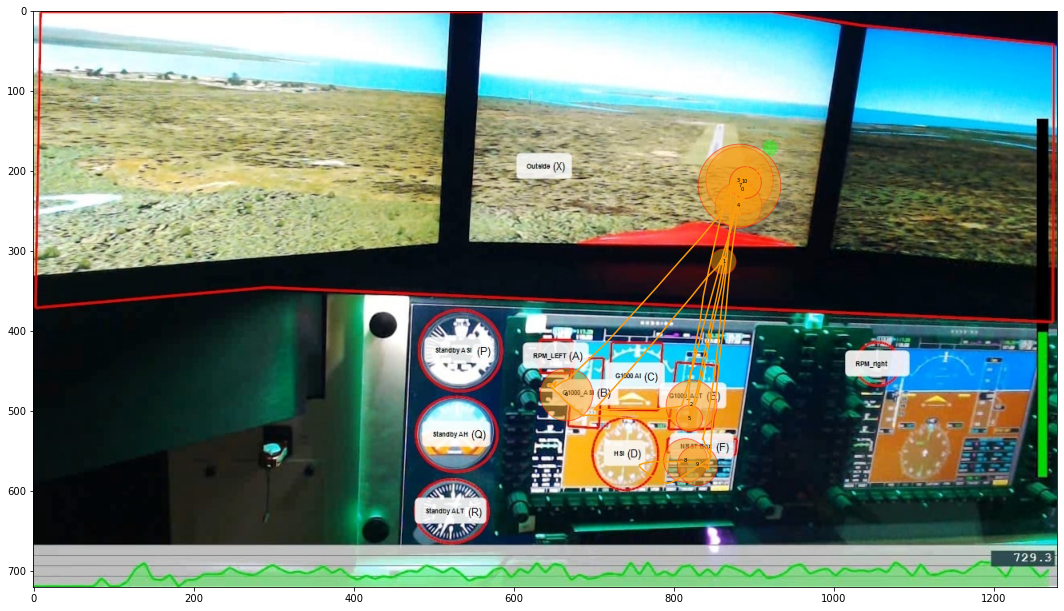

In [81]:

siz = 3000 * df_efix["duration"].values
col = "#fa9c0f"
edge_col = "#fa130f"

img = plt.imread("flight.jpg")
fig=plt.figure(figsize=(15,8))
ax=fig.add_axes([0,0,1,1])
ax.imshow(img)

for i, (_x,_y,s) in enumerate(zip(df_efix['x'].values, df_efix['y'].values, siz)):
    if i > 10:
        break
    ax.scatter(int(_x), int(_y), s = s, c=col, edgecolors=edge_col, marker='o', alpha=0.5)
    plt.annotate(str(i), xy = (_x,_y), va= "center", ha="center", fontsize = 5)
    ax.plot
#     ax.scatter(x[3], x[4], s = siz, c=col, edgecolors=edge_col, marker='o', cmap='jet', alpha=0.5)

gaze_points = df_data[df_data["Start Time (secs)"] < df_efix.iloc[10,1]].dropna()[["X Pos", "Y Pos"]].astype("int").values
ax.plot(gaze_points.T[0], gaze_points.T[1], c= col)


# Find repeated sequence

In [17]:
encode_table={
    "standby_ASI": "P",
    "standby_AH": "Q",
    "standby_ALT": "R",
    "RPM_LEFT": "A",
    "G1000_ASI": "B",
    "G1000_AI": "C",
    "HSI": "D",
    "G1000_ALT": "E", 
    "NRST_Box": "F",
    "RPM_RIGHT": "I",
    "outside": "X",
    "unknown": "Z"
}

In [18]:
encode_table = {
    "left_panel": "P",
    "ASI": "B",
    "HSI": "D",
    "ALT": "E",
    "outside": "X",
    "unknown": "Z"
}

In [19]:
def encode(lst_transition):
    str_transition = ""
    for v in lst_transition:
        str_transition = str_transition + encode_table[v]
    return str_transition

def decode(str_transition):
    lst_transition = []
    for v in str_transition:
        key_index = list(encode_table.values()).index(v)
        lst_transition.append(list(encode_table.keys())[key_index])
    return lst_transition

# encode(['outside', 'RPM_LEFT', 'G1000_ASI', 'outside'])
# decode("XABX")
encode(['outside', 'ALT'])

'XE'

In [20]:
def get_scanpath(df_data):
    df_x = df_data.copy()
    
    if (len(df_data[df_data["Display"] == -1])/len(df_data) > 0.30): # if missing value > 30%, remove
        return [], pd.DataFrame()
    
    Efix = eye_metrics_utils.detect_fixations(df_x, max_dist = 10, min_dur = 6, is_cleanup = True)
    
    l = []

    for i, fix in enumerate(Efix):
        point = np.array([fix[4], fix[3]], dtype ="int64")
        
        d = [dist_func((point[1],point[0]), v1,v2,type) for v1,v2,type in label.values()]
        order = np.argsort(d)
        if 0.0 not in d:
            threshold = 20
            if d[order[0]] > threshold:
                key = "unknown"
            else:
                key = list(pdict.keys())[order[0]]
        else:
            for o in order:
                key = "unknown"
                points = np.transpose(list(pdict.values())[o])
        #         if v in point:
                if any((points[:]==point).all(1)):
                    key = list(pdict.keys())[o]
                    break
        
        Efix[i].append(key)
#         for i in range(int(1000*fix[2]/50)):
#             l.append(key)
        l.append(key)
    str_transition = encode(l)
    
    return str_transition, Efix

In [21]:
def merge_consecutive_fixations_in_same_roi(efix):
    if(len(efix) == 0):
        return efix
    df_efix = pd.DataFrame(efix, columns=["start", "stop", "duration", "x", "y", "roi"])
    df_efix['value_grp'] = (df_efix.roi != df_efix.roi.shift()).cumsum()

    return pd.DataFrame({'start' : df_efix.groupby('value_grp').start.first(), 
                          'stop' : df_efix.groupby('value_grp').stop.last(),
                          'duration' : df_efix.groupby('value_grp').duration.sum(), 
                          'x' : df_efix.groupby('value_grp').x.mean(),
                          'y': df_efix.groupby('value_grp').y.mean(),
                          'roi': df_efix.groupby('value_grp').roi.first()
                         }).reset_index(drop=True).to_numpy()

In [22]:
def get_feature_from_fixation(efix):
    df_fix = merge_consecutive_fixations_in_same_roi(efix)
    df_fix = pd.DataFrame(efix, columns=['start','stop','fix_dur','x','y','roi'])

    f = defaultdict(dict)
    for key in label.keys():
        df_f = df_fix[df_fix['roi'] == key]
        if len(df_f['fix_dur']) == 0:
            f[key]['fix_dur'] = 0
            f[key]['fix_rate'] = 0
        else:
            f[key]['fix_dur'] = np.median(df_f['fix_dur'])
#             f[key]['fix_rate'] = df_f['fix_dur'].sum()/df_fix['fix_dur'].sum()
#             f[key]['fix_rate'] = len(df_f['fix_dur'])/len(df_fix)            
            f[key]['fix_rate'] = (1000/60)*len(df_f['fix_dur'])/(df_fix.iloc[-1]['stop'] - df_fix.iloc[0]['start'])


    return f

In [23]:
import re
# st = "FXCEFXXEFXBZXXXXXEFXDBXZXXEDXCBXFXXXXZ"

def replace_repeated_character(st): 
    return re.sub(r'(\w)\1+',r'\1', st)

In [24]:
def get_feature(df_data):
    df_x = df_data.copy()
    if (len(df_data[df_data["Display"] == -1])/len(df_data) > 0.30): # if missing value > 20%, remove
        return None, None
    
    total_time = df_x.iloc[-1]['Start Time (secs)'] - df_x.iloc[0]['Start Time (secs)']
    
#     Efix = eye_metrics_utils.detect_fixations(df_x, max_dist = 10, min_dur = 10)
    Eblk = eye_metrics_utils.detect_blinks(df_x)
    Esac = eye_metrics_utils.detect_saccades(df_x)
    
#     fix_dur = np.mean(np.array(Efix).T[2])
#     fix_rate = len(Efix)
    blk_rate = (1000/60)*len(Eblk)/total_time
    sac_rate = (1000/60)*len(Esac)/total_time
    
    return blk_rate, sac_rate
#     return fix_dur, fix_rate, blk_rate, sac_rate

In [25]:
def cal_entropy(transitions):
    if len(transitions) == 0:
        return 0, 0
#     transitions = replace_repeated_character(transitions)

    trans_matrix = create_transition_matrix(transitions)

    m = {}
    for c in trans_matrix.columns:
        m[c] = trans_matrix[c].tolist()
    # m = {c: trans_matrix[c].tolist() for c in trans_matrix.columns}

    Hs = 0
    Ht = 0
    pA = {c:len(np.where(np.array(list(transitions))==c)[0])/len(transitions) for c in list(set(transitions))}

    for k,v in pA.items():
        Hs += -1 * np.nan_to_num(v*np.log2(v))

#         t = np.nan_to_num(m[k]*np.log2(m[k]))
        Ht += -sum(pA[k]*(np.nan_to_num(m[k]*np.log2(m[k]))))
        
    return Hs, Ht

In [26]:
def create_transition_matrix(transitions):
    m = pd.crosstab(pd.Series(list(transitions)[1:], name = "t+1"),
            pd.Series(list(transitions)[:-1], name = "t"),normalize=1)
        
    return m

In [20]:
import glob
csv_files = glob.glob("data/*.csv")
# csv_files_two = [v for v in csv_files if "Two Gaze-Vergence" in v]
csv_files_two = [v for v in csv_files if "Three Go-Around Gaze-Vergence" in v]

In [21]:
# df_par

In [22]:
df_par = pd.read_csv("participant.csv")
group = [df_par[df_par['Group'].str.contains("1")]['ID'].tolist(), df_par[df_par['Group'].str.contains("2")]["ID"].tolist()]
group = [[i[-3:] for i in v] for v in group]

In [23]:
group2 = [df_par[df_par['Group'].str.contains(gr)]['ID'].tolist() for gr in ["A", "B", "C"]]
group2 = [[i[-3:] for i in v] for v in group2]
group2

[['032',
  '027',
  '031',
  '028',
  '004',
  '008',
  '010',
  '029',
  '003',
  '007',
  '023',
  '013',
  '024'],
 ['021', '006', '019', '022', '015', '016', '018', '033'],
 ['014', '005', '025', '002', '001', '020', '011', '017', '026', '012', '009']]

In [24]:
d = defaultdict(list)
Efixs = {}
for csv in csv_files_two:
    par_id = csv[14:17]
    
#     if par_id in ["011", "016", "005"]: # remove 3 participants from group 2 to make 2 group equal size 
#         continue
    
    df_data = pd.read_csv(csv)
    print(csv, len(df_data))
    
    if par_id in group2[0]:
        g = 1
    elif par_id in group2[1]:
        g = 2
    elif par_id in group2[2]:
        g = 3
    
    d['par_id'].append(par_id)
    d['group'].append(g)
    
    df_data = offset(df_data)
    
    transition, Efix = get_scanpath(df_data)
#     Efix = merge_consecutive_fixations_in_same_roi(Efix)
    d['transition'].append(transition)
    Efixs[par_id]=Efix
    f = get_feature_from_fixation(Efix)
    for key,v in f.items():
        d["{}_fix_dur".format(key)].append(v['fix_dur'])
        d["{}_fix_rate".format(key)].append(v['fix_rate'])

#     fix_dur, fix_rate, blk_rate, sac_rate = get_feature(df_data)
    df_efix = pd.DataFrame(Efix, columns=["start", "stop", "duration", "x", "y", "roi"])
#     fix_dur = df_efix[df_efix["roi"] != "outside"]["duration"].mean()
#     fix_rate = df_efix[df_efix["roi"] != "outside"]["duration"].count()/(len(df_efix) + 0.0001)
    fix_dur = df_efix["duration"].median()
    fix_rate = (1000/60)*len(df_efix)/(df_data.iloc[-1]['Start Time (secs)'] - df_data.iloc[0]['Start Time (secs)'])
    blk_rate, sac_rate = get_feature(df_data)

    d["fix_dur"].append(fix_dur)
    d["fix_rate"].append(fix_rate)
    d["blk_rate"].append(blk_rate)
    d["sac_rate"].append(sac_rate)

    Hs, Ht = cal_entropy(transition)
    d["Hs"].append(Hs)
    d["Ht"].append(Ht)  

data\PISSS_ID_001_Approach Three Go-Around Gaze-Vergence.csv 2465
data\PISSS_ID_002_Approach Three Go-Around Gaze-Vergence.csv 616
data\PISSS_ID_003_Approach Three Go-Around Gaze-Vergence.csv 2157
data\PISSS_ID_004_Approach Three Go-Around Gaze-Vergence.csv 1849
data\PISSS_ID_005_Approach Three Go-Around Gaze-Vergence.csv 2230
data\PISSS_ID_006_Approach Three Go-Around Gaze-Vergence.csv 2033
data\PISSS_ID_007_Approach Three Go-Around Gaze-Vergence.csv 2096
data\PISSS_ID_009_Approach Three Go-Around Gaze-Vergence.csv 1849
data\PISSS_ID_010_Approach Three Go-Around Gaze-Vergence.csv 2589
data\PISSS_ID_011_Approach Three Go-Around Gaze-Vergence.csv 2157
data\PISSS_ID_012_Approach Three Go-Around Gaze-Vergence.csv 1911
data\PISSS_ID_013_Approach Three Go-Around Gaze-Vergence.csv 2034
data\PISSS_ID_014_Approach Three Go-Around Gaze-Vergence.csv 2096
data\PISSS_ID_015_Approach Three Go-Around Gaze-Vergence.csv 2033
data\PISSS_ID_016_Approach Three Go-Around Gaze-Vergence.csv 2219
data\PISSS_

In [25]:
df_res = pd.DataFrame(d).sort_values(["group","par_id"]).dropna().reset_index()

In [26]:
exp = [df_par[df_par["ID"].str.contains(str(v).zfill(3))]["Flight_hour"].tolist()[0] for v in df_res["par_id"]]

In [27]:
df_res["exp"] = exp

In [28]:
df_res[["group", "par_id", "exp"]].groupby("group").max()

,par_id,exp
group,,
1,032,50
2,022,200
3,026,420


In [29]:
# df_res = pd.read_csv("res.csv")

In [30]:
# df_res[["par_id", "group", "fix_rate", "fix_dur", "outside_fix_rate", "outside_fix_dur", "G1000_ASI_fix_rate", "G1000_ALT_fix_rate", "G1000_AI_fix_rate", "RPM_LEFT_fix_rate"]]

In [31]:
x = df_res['transition'].tolist()
x= [replace_repeated_character(v) for v in x]

In [32]:
x

['XZXZBZXBZXZXEXEXEXEXEXZDXZX',
 'XEBXBEDXBXZEDZEXDEDEDEDXEBXDEDEDED',
 'XZXBEXBXZEBXEDXBEZXDEDZDXZDZDBEZXZD',
 'XEBXBXEXEBXBXEBEXEXZBEBXBXEDXEBXDZEBXDEXEDB',
 'BXBXDXZXDXBXZDEXZEDXDEZEZXD',
 'XDXDXEDXEDXZEZXZXEXDXDXDXEDXEXZXDXEXEX',
 'BEDEDEDEDEDEDEDEXEDE',
 'XZXBXBXEXEXEXBZXEXZEXEXE',
 'XEXEBXBXBXBXBXBXBXBXBXE',
 'XBXBXDEDEDEDEDEDE',
 'BEDEBXEBXBXDEDXEXBXBXZXZDBXBXD',
 'XDXEXEXEDXEXEXDXEDXDXDX',
 'XEXDXBXBEBXZBXBEBXEBDXZDEXEDEXBZXD',
 'XBXBXBEBXDBXDEBXEDXZDEXEXEDBDXBZXE',
 'XBXBXBEBEXEBXBEXBEXBEBXBEDEXEBDEBEDEBDEBEBEDEBXDE',
 'BZBDEXEXDXDXEDXDXDE',
 'XBXEBXBEBEDEBEBEBEDEZDEDEXBEBZEDZ',
 'XEXDXEXEDEBEDEXEDX',
 'XDXDXDXDEXDXEXDXEXEXEXDXEX',
 'XBXBEXBEBEBEBXDZBZEXEXBZDZEDBZXBZEBDEZBEDEBDXEDBZEBEDEBEZ',
 'XBEXBX',
 'BXZXBXBEZXZXBEBXBZXBEBZEDXZEDE',
 'XBXEBEBEXEBEXZXZEBXZBEXBXEDZBXEBZEBZ',
 'XBEXZBZXBEDBXBEDEDEBDXEZEBX',
 'XZXZXZXZEBEXZXZDZEDEZBZBXBEBEDEDZEDBEDED',
 'BXEXEBEBEBEBEBDBXDEBXEBEBZBEBEBDBDZEBDEBEBEBEBEDB',
 'XBXBXEBXDEDEXDEBE',
 'XEXBEXEDXDBDEDXDBXDXZEDXBXEDEDBDED',
 'DXDBEXDE

In [33]:
# a = replace_repeated_character(str(df_res[df_res['par_id'] == 23]['transition'].values[0]))

In [34]:
df_res['transition'].tolist()

['XXXZXXZBZXBZXXZZXEXEXEXEEEXXEXZDXZX',
 'XXEBXXBEDXBXZEDZEXDDEDEDEDXEBXDEDEDED',
 'XXXZXXBEXBXZEBXEEDXXBEZZXDEDZDXXZDZDBEZXZD',
 'XXXEBXBXEXEBXBXEBEXEXZBEBXBXEDXEBXDZEBXDEXEDB',
 'BBXXBXDXZXDXBXZDEXZEDXDEZEZXD',
 'XXDXXDXXEDXEDXZEZXZXEXDXDXXXXXDXEDXEEXZXDXEXXEX',
 'BEDEDEDEEEDEEDEDEDEXEDEE',
 'XXXXXXXZXBXBXXXEXEXEEXBBZXEEXXZEXXXEEEEXEE',
 'XXXXXEXXXXEBXBXXXBXBXBXBXBXXXXXBXBXE',
 'XXBXXXBXDEDDEDDEDEDDEDE',
 'BBEDEBXEBXBXXXDEDDXEEXBXBXZXZDDBXBXXDD',
 'XXXXXDXEXXEXXEDXEXEXDXXEEDXDXDX',
 'XEXDXXXXBXXBEBXZBXBEBXEBDXZDEXEDEXBZXD',
 'XXXXBXBXBEBXXXDBXXDEBXEDXZDEXEEXXEEDBDXBZXE',
 'XXXBXBXBEBEXXEBXBEXBEXBEBXBEDEXEBDEBEDEBDEBEBEDEBXDE',
 'BZBDEXXEXDXDDXXEDDXXDXDE',
 'XXBXEBXBEBEDEBEBEEBEDEEZDEDEXBEBZEDZ',
 'XXXEXDXXEXEDEEEEBEDEEXXXEDX',
 'XXXXXDXDXDXDEXDXEXDXEXEXEXDXEX',
 'XXXXBXBEXBEBEBEBXDZBZEXEXBZDZEDBZXXBZEBDEZBEDEBDXEDBZEBEDEEBEZZ',
 'XXBEXBBX',
 'BXZXBXBEZXZXBEBXXBBZXBEBBZEDXXZEDE',
 'XXBXXEBEBBEEXEBEXXXXZXZEBXXZBEXBXXEDZBXEBZEBZ',
 'XXXBEXXZBZXXBEDBXXXXXBEDEDEBDXXXEZEBXX',
 'XXXXXXZXZXZ

# suffix tree

In [35]:
import STree

# # Suffix-Tree example.
# st = STree.STree("abcdefghab")
# print(st.find("abc")) # 0
# print(st.find_all("ab")) # [0, 8]

# # Generalized Suffix-Tree example.
# a = ["xxxabcxxx", "adsaabc", "ytysabcrew", "qqqabcqw", "aaabc"]
# st = STree.STree(a)
# print(st.lcsm()) # "abc"

In [36]:
st = STree.STree(x)

In [37]:
ws = st.word_starts

In [38]:
np.array([len(v) for v in x])

array([27, 34, 35, 43, 27, 38, 20, 24, 23, 17, 30, 23, 34, 34, 49, 19, 33,
       18, 26, 57,  6, 30, 36, 27, 40, 49, 17, 34, 22])

In [39]:
st.lcsm()

['X', 'E']

In [60]:
# substrs = ["BX", "XBX", "XEX", "XEB", "XBE", "BEX", "XBXB", "BXBX", "XBXE", "EXBX", "XBEX", "XEBX"]
# substrs = ["BXEX", "XEXB", "XEX", "XEB", "XBXB", "XBXBX"]
# substrs = ["XBX", "BXBX", "XBXBX", "BXBXBX", "XBXBXBX"]
substrs = ["EDE", "DEDE", "DEDED", "BXBXBX", "XBXBXBX"]


for substr in substrs:
    find = np.array(list(st.find_all(substr)))
    print(substr, len(find))
    r = []
    for i in range(len(ws) - 1):
        l = len(np.where((find > ws[i]) & (find < ws[i + 1]))[0])
        r.append(l)
    r.append(len(find) - sum(r))
    r = np.array(r) / np.array([len(v) for v in x])
#     print(r)
    df_res['n_{}'.format(substr)] = r

EDE 41
DEDE 22
DEDED 16
BXBXBX 7
XBXBXBX 6


# find frequency of sub-sequences

In [63]:

length = 5
subseq = defaultdict(int)

for string in x:
    c = 0
    for i in range(len(string)-length + 1):
        substring = string[i:i+length]
        subseq[substring] += 1
        if substring == "XBXBXBX":
            c += 1
    print(c)
    
#     ss = {k: v for k, v in sorted(subseq.items(), key=lambda item: item[1], reverse=True)}
    
#     df_res["s3"] =


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [64]:
{k: v for k, v in sorted(subseq.items(), key=lambda item: item[1], reverse=True)}

{'DEDED': 16,
 'EDEDE': 15,
 'XBXBX': 13,
 'XEXEX': 11,
 'EBEBE': 11,
 'BXBXB': 9,
 'BEBEB': 9,
 'EXEXE': 8,
 'XEBXB': 7,
 'XDXDX': 7,
 'XEXDX': 7,
 'EBEDE': 7,
 'BXBXE': 6,
 'XDXEX': 6,
 'BEDEB': 6,
 'BXBEB': 6,
 'XDEDE': 5,
 'XBEXB': 5,
 'EBXBX': 5,
 'DXEDX': 5,
 'DXDXD': 5,
 'DXEXE': 5,
 'EXDXE': 5,
 'XBXBE': 5,
 'XBEBX': 5,
 'BEBED': 5,
 'EBXBE': 4,
 'EBXDE': 4,
 'BXDED': 4,
 'XBXEB': 4,
 'XEDXE': 4,
 'DEXED': 4,
 'BXBXD': 4,
 'XDXED': 4,
 'BEDED': 4,
 'XBEBE': 4,
 'BXBED': 3,
 'XEBXD': 3,
 'BEXBX': 3,
 'BXEDX': 3,
 'BXEXE': 3,
 'XEXEB': 3,
 'EXEBX': 3,
 'BXEBE': 3,
 'EBEXE': 3,
 'BEBXB': 3,
 'XBXED': 3,
 'XZDEX': 3,
 'DXDXE': 3,
 'EDXEX': 3,
 'DEDEX': 3,
 'EDEXE': 3,
 'EXEDE': 3,
 'DEBXE': 3,
 'EBXEB': 3,
 'BXEBX': 3,
 'XEXED': 3,
 'EXEDX': 3,
 'EXEXD': 3,
 'XEDXD': 3,
 'BEXBE': 3,
 'EXBEB': 3,
 'EBDEB': 3,
 'BDEBE': 3,
 'EDEBD': 3,
 'DEBEB': 3,
 'EDEBE': 3,
 'XEBEB': 3,
 'XZBZX': 2,
 'ZBZXB': 2,
 'BZXBZ': 2,
 'ZXZXE': 2,
 'XZXEX': 2,
 'EXEXZ': 2,
 'EDXBX': 2,
 'DXBXZ': 2,
 'XBXZE

# scanpath similarity

In [65]:
def bag_of_words(string, sublen = 4):
    subseq = defaultdict(int)
    for i in range(len(string)-sublen + 1):
        substring = string[i:i+sublen]
        subseq[substring] += 1
        
#     norm = sum(subseq.values())
    norm = len(string) - sublen + 1
    subseq = {k:v/norm for k,v in subseq.items()}
    
    return subseq

In [66]:
def compare_distance(bag1, bag2):
    keys_a = set(bag1.keys())
    keys_b = set(bag2.keys())
    intersection = keys_a & keys_b
    mismatch_a = keys_a - intersection
    mismatch_b = keys_b - intersection

    val_a = list(map(bag1.get, list(intersection)))
    val_b = list(map(bag2.get, list(intersection)))

    val_mismatch_a = sum(list(map(bag1.get, list(mismatch_a))))
    val_mismatch_b = sum(list(map(bag2.get, list(mismatch_b))))

    dist = 0
    for i in range(len(val_a)):
        dist += abs(val_a[i] - val_b[i])

    dist += val_mismatch_a + val_mismatch_b

    return 1 - dist/2

In [67]:
par_id = df_res['par_id'].tolist()

In [68]:
length = 5
dcomp = defaultdict(list)
for i in range(len(x)):
    for j in range(len(x)):
        bag1 = bag_of_words(x[i], sublen = length)
        bag2 = bag_of_words(x[j], sublen = length)
        dist = compare_distance(bag1, bag2)
        dcomp[par_id[i]].append(dist)
        
df_comp = pd.DataFrame(dcomp)
df_comp.insert(loc=0, column='par_id', value=par_id)

In [69]:
df_comp.to_csv("similarity.csv", index=False)

In [70]:
# df_res[["par_id", "group","exp"]].sort_values(by=["exp"])

In [104]:
d_exp = {k:v for k,v in zip(par_id, exp)}
d_exp = {k: v for k, v in sorted(d_exp.items(), key=lambda item: item[1], reverse=False)}

In [105]:
df_comp2 = df_comp.set_index("par_id")[list(d_exp.keys())]
df_comp2 = df_comp2.loc[list(d_exp.keys()),:]

Text(0.5, 1.05, 'scanpath correlation')

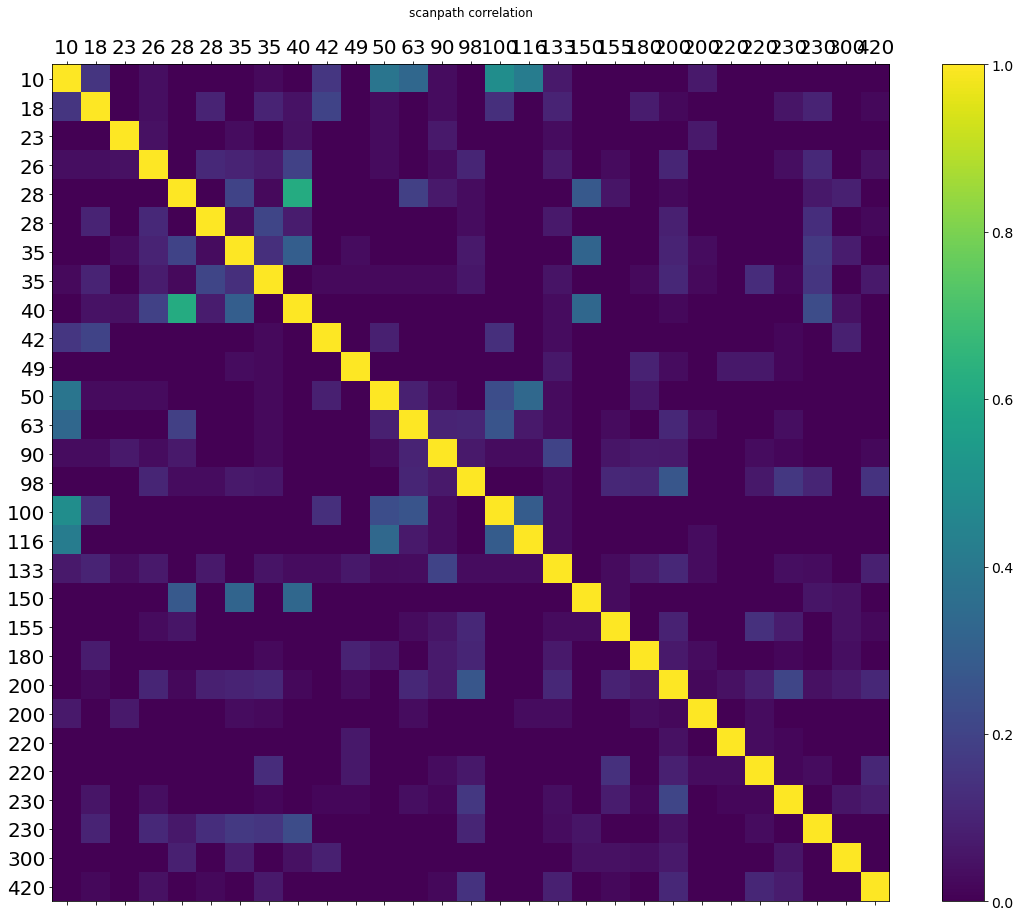

In [106]:
f = plt.figure(figsize=(19, 15))
# plt.pcolor(df_comp2)
plt.matshow(df_comp2, fignum=f.number)
plt.yticks(np.arange(0, len(df_comp2.index), 1), list(d_exp.values()))
# plt.xticks(np.arange(0, len(df_comp2.columns), 1), df_comp2.columns)
plt.xticks(np.arange(0, len(df_comp2.columns), 1), list(d_exp.values()))
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title("scanpath correlation")

In [74]:
group = df_res['group'].tolist()
sgroup = []
for gr in group:
    sgr = ""
    if gr == 1:
        sgr = "Pre"
    elif gr == 2:
        sgr = "PPL"
    elif gr == 3:
        sgr = "CPL"
    sgroup.append(sgr)

In [75]:
from scipy.cluster.hierarchy import dendrogram, linkage


In [76]:
ddist = df_comp.iloc[:,1:].to_numpy()

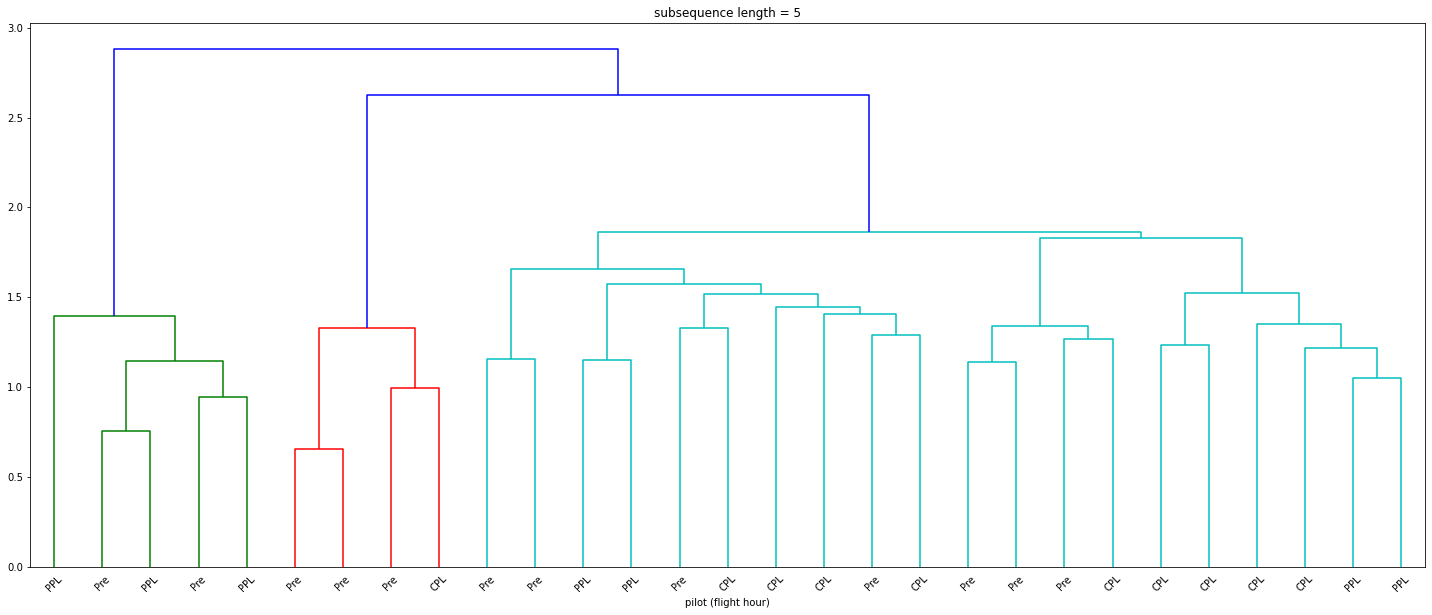

In [77]:
labels = ["{}({})".format(u,v) for u,v in zip(par_id,exp)]
Z = linkage(ddist, 'ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z, labels = sgroup)

# Z = linkage(X, 'single')
# fig = plt.figure(figsize=(25, 10))
# dn = dendrogram(Z)
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20) 
plt.xlabel("pilot (flight hour)")
plt.title("subsequence length = {}".format(length))
plt.show()

In [78]:
exp

[42,
 35,
 49,
 35,
 23,
 50,
 28,
 18,
 28,
 40,
 26,
 10,
 90,
 133,
 200,
 116,
 98,
 63,
 100,
 230,
 220,
 180,
 220,
 300,
 155,
 420,
 230,
 200,
 150]

In [53]:
# df_res1 = df_res.drop(columns=[ "transition", "standby_ASI_fix_dur", "standby_ASI_fix_rate", "standby_AH_fix_dur",
#                      "standby_AH_fix_rate", "standby_ALT_fix_dur", "standby_ALT_fix_rate", "RPM_RIGHT_fix_dur", "RPM_RIGHT_fix_rate",
#                               "RPM_LEFT_fix_rate", "RPM_LEFT_fix_dur"])

In [79]:
df_res1 = df_res.drop(columns=[ "transition"])

In [80]:
df_res1

,index,par_id,group,outside_fix_dur,outside_fix_rate,left_panel_fix_dur,left_panel_fix_rate,ASI_fix_dur,ASI_fix_rate,ALT_fix_dur,...,Ht,exp,n_XBX,n_BXBX,n_XBXBX,n_BXBXBX,n_XBXBXBX,n_EDE,n_DEDE,n_DEDED
0,2,003,1,0.485026,8.100380,0,0,0.413521,0.952986,0.454036,...,1.412185,42,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
1,3,004,1,0.296015,5.049391,0,0,0.395532,2.244174,0.502025,...,1.435369,35,0.029412,0.000000,0.000000,0.000000,0.00000,0.117647,0.117647,0.117647
2,6,007,1,0.439523,6.864616,0,0,0.666034,2.451648,1.073032,...,1.872552,49,0.028571,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
3,8,010,1,0.517025,6.351000,0,0,0.976035,4.366313,0.690069,...,1.482135,35,0.069767,0.069767,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
4,11,013,1,0.395017,5.409611,0,0,0.786018,2.163844,0.389043,...,1.418788,23,0.074074,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
5,21,023,1,0.344032,13.896977,0,0,0.000000,0.000000,0.264032,...,1.426900,50,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
6,22,024,1,0.096023,0.736319,0,0,0.377991,0.736319,0.495034,...,0.722692,28,0.000000,0.000000,0.000000,0.000000,0.00000,0.400000,0.300000,0.250000
7,25,027,1,0.382520,9.916909,0,0,0.731538,1.803074,0.406008,...,1.417714,18,0.083333,0.041667,0.041667,0.000000,0.00000,0.000000,0.000000,0.000000
8,26,028,1,0.521977,11.436481,0,0,0.712000,4.288680,0.587027,...,1.004958,28,0.347826,0.347826,0.304348,0.304348,0.26087,0.000000,0.000000,0.000000
9,27,029,1,0.564027,3.581223,0,0,0.416520,1.193741,0.626022,...,0.739980,40,0.058824,0.058824,0.000000,0.000000,0.00000,0.294118,0.294118,0.235294


# independent t-test

In [81]:
import scipy

In [82]:
# standardized effect size - cohen's d 
def effect_size(x, y):
#     es = np.abs(np.mean(a) - np.mean(b))
#     sd_pooled = np.sqrt((((len(a)-1)*(np.std(a)**2) + (len(b)-1)*(np.std(b)**2)) / (len(a) + len(b) - 2)))
#     d = es/sd_pooled
    
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return abs((np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof))

    
    return d

In [83]:
def statistical_testing(df_res, test_type = "t"):
    df_g1 = df_res[df_res["group"] == 1]
    df_g2 = df_res[df_res["group"] == 2]
    
    if test_type == "u":
        test = scipy.stats.mannwhitneyu
    elif test_type == "t":
        test = scipy.stats.ttest_ind
    elif test_type == "a":
         test = scipy.stats.f_oneway
    tval = []
    pval = []
    ez = []
    for col in cols:
        t,p = test(df_g1.loc[:,col], df_g2.loc[:,col])
        e = effect_size(df_g1.loc[:,col], df_g2.loc[:,col])
        tval.append(t)
        pval.append(p)
        ez.append(e)

    return pd.DataFrame(zip(cols,tval,pval,ez), columns = ['ROI','tval','pval','effect size'])
    # print(col, scipy.stats.mannwhitneyu(df_g1.loc[:,col], df_g2.loc[:,col]))

In [84]:
def stats(df_res):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-84-6630760b2966>, line 2)

In [85]:
import scipy.special as special

def FPvalue( *args):
    """ Return F an p value

    """
    df_btwn, df_within = __degree_of_freedom_( *args)

    mss_btwn = __ss_between_( *args) / float( df_btwn)   
    mss_within = __ss_within_( *args) / float( df_within)

    F = mss_btwn / mss_within    
    P = special.fdtrc( df_btwn, df_within, F)

    return( F, P)

def EffectSize( *args):
    """ Return the eta squared as the effect size for ANOVA

    """    
    return( float( __ss_between_( *args) / __ss_total_( *args)))

def __concentrate_( *args):
    """ Concentrate input list-like arrays

    """
    v = list( map( np.asarray, args))
    vec = np.hstack( np.concatenate( v))
    return( vec)

def __ss_total_( *args):
    """ Return total of sum of square

    """
    vec = __concentrate_( *args)
    ss_total = sum( (vec - np.mean( vec)) **2)
    return( ss_total)

def __ss_between_( *args):
    """ Return between-subject sum of squares

    """    
    # grand mean
    grand_mean = np.mean( __concentrate_( *args))

    ss_btwn = 0
    for a in args:
        ss_btwn += ( len(a) * ( np.mean( a) - grand_mean) **2)

    return( ss_btwn)

def __ss_within_( *args):
    """Return within-subject sum of squares

    """
    return( __ss_total_( *args) - __ss_between_( *args))

def __degree_of_freedom_( *args):
    """Return degree of freedom

       Output-
              Between-subject dof, within-subject dof
    """   
    args = list( map( np.asarray, args))
    # number of groups minus 1
    df_btwn = len( args) - 1

    # total number of samples minus number of groups
    df_within = len( __concentrate_( *args)) - df_btwn - 1

    return( df_btwn, df_within)

In [86]:
def oneway(df_res):
    df_g1 = df_res[df_res["group"] == 1]
    df_g2 = df_res[df_res["group"] == 2]
    df_g3 = df_res[df_res["group"] == 3]

    fval = []
    pval = []
    ez = []
    for col in cols:
        f,p = FPvalue(df_g1.loc[:,col], df_g2.loc[:,col], df_g3.loc[:,col])
        
        e = EffectSize(df_g1.loc[:,col], df_g2.loc[:,col], df_g3.loc[:,col])
        fval.append(f)
        pval.append(p)
        ez.append(e)

    return pd.DataFrame(zip(cols,fval,pval,ez), columns = ['ROI','F','pval',"effectSize"])

In [87]:
# oneway(df_res1)

In [88]:
scipy.stats.f_oneway

<function scipy.stats.stats.f_oneway(*args)>

In [89]:
# df_g1 = df_res1[df_res1["group"] == 1]
# df_g2 = df_res1[df_res1["group"] == 2]

In [90]:
cols = df_res1.columns.tolist()[3:]

In [91]:
# df_par

In [92]:
# df_res1[["par_id", "group", "fix_rate", "fix_dur"]]

In [93]:
df_g1 = df_res[df_res["group"] == 1]
df_g2 = df_res[df_res["group"] == 2]
df_g1['outside_fix_dur'].mean(), df_g2['outside_fix_dur'].mean()

(0.42418991666667694, 0.38123978571426925)

In [94]:
print("t-test: missing = 15%, max_dist = 10, min_dur = 10")
statistical_testing(df_res1, test_type="t")

t-test: missing = 15%, max_dist = 10, min_dur = 10


,ROI,tval,pval,effect size
0,outside_fix_dur,0.687450,0.501071,0.326948
1,outside_fix_rate,0.423247,0.677421,0.201294
2,left_panel_fix_dur,NaN,NaN,NaN
3,left_panel_fix_rate,NaN,NaN,NaN
4,ASI_fix_dur,0.109194,0.914327,0.051932
5,ASI_fix_rate,-1.098908,0.287128,0.522635
6,ALT_fix_dur,0.221104,0.827645,0.105156
7,ALT_fix_rate,-0.834388,0.415634,0.396831
8,HSI_fix_dur,-1.454461,0.164033,0.691734
9,HSI_fix_rate,-0.003772,0.997034,0.001794


In [95]:
print("U-test: missing = 15%, max_dist = 10, min_dur = 10")
statistical_testing(df_res1, test_type="u")

U-test: missing = 15%, max_dist = 10, min_dur = 10


ValueError: All numbers are identical in mannwhitneyu

In [96]:
print("ANOVA 1 way test: missing = 15%, max_dist = 10, min_dur = 10")
oneway(df_res1)

ANOVA 1 way test: missing = 15%, max_dist = 10, min_dur = 10


,ROI,F,pval,effectSize
0,outside_fix_dur,1.127813,3.390702e-01,0.079829
1,outside_fix_rate,0.966255,3.937533e-01,0.069185
2,left_panel_fix_dur,NaN,NaN,NaN
3,left_panel_fix_rate,NaN,NaN,NaN
4,ASI_fix_dur,0.058564,9.432422e-01,0.004485
5,ASI_fix_rate,2.504244,1.012526e-01,0.161520
6,ALT_fix_dur,1.395636,2.656211e-01,0.096949
7,ALT_fix_rate,0.477898,6.254252e-01,0.035458
8,HSI_fix_dur,1.397861,2.650878e-01,0.097088
9,HSI_fix_rate,0.224161,8.007147e-01,0.016951


In [57]:
oneway(df_res1).to_csv("oneway.csv")

In [107]:
#post-hoc analysis using Tukey
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=df_res['n_BXBXBX'], groups=df_res['group'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2  -0.0254 0.6179 -0.0929 0.0422  False
     1      3  -0.0254 0.5589 -0.0862 0.0354  False
     2      3      0.0    0.9   -0.07   0.07  False
---------------------------------------------------


# Correlation

In [81]:
from scipy import stats

In [82]:
def corr(df_res, test_type = "s"):
    cols = df_res.columns.tolist()[3:-1]
    exp = df_res["exp"]
    if test_type == "s":
        test = scipy.stats.spearmanr
#     elif test_type == "t":
#         test = scipy.stats.ttest_ind
    rho = []
    pval = []
#     ez = []
    for col in cols:
        r, p = test(df_res.loc[:,col], exp)
        e = effect_size(df_res.loc[:,col], exp)
        rho.append(r)
        pval.append(p)
#         ez.append(e)

    return pd.DataFrame(zip(cols,rho,pval), columns = ['ROI','rho','pval'])

    # print(col, scipy.stats.mannwhitneyu(df_g1.loc[:,col], df_g2.loc[:,col]))

In [83]:
corr(df_res1, "s")

,ROI,rho,pval
0,outside_fix_dur,0.340459,0.095849
1,outside_fix_rate,-0.386675,0.056208
2,left_panel_fix_dur,-0.178541,0.393165
3,left_panel_fix_rate,-0.206287,0.322505
4,ASI_fix_dur,-0.365877,0.072069
5,ASI_fix_rate,0.454458,0.022474
6,ALT_fix_dur,-0.198344,0.341890
7,ALT_fix_rate,0.099750,0.635214
8,HSI_fix_dur,0.142912,0.495562
9,HSI_fix_rate,0.283128,0.170244


In [2]:
df_res = pd.read_csv("res.csv")

# Logistic regression

In [3]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import r2_score

import statsmodels.api as sm
from scipy import stats

In [11]:
cols = df_res.columns.tolist()[3:]
r2 = []
for col in cols: 
    y = df_res[col].values
#     X = MinMaxScaler().fit_transform(X)

    X = df_res['exp'].values.reshape(-1,1)
    clf = LinearRegression().fit(X, y)
    pred = clf.predict(X)
    r2.append(np.round(r2_score(y,pred),3))

In [12]:
pd.DataFrame(zip(cols,r2), columns = ["var", "r2"])

,var,r2
0,outside_fix_dur,0.068
1,outside_fix_rate,0.070
2,outside_fix_percent,0.050
3,left_panel_fix_dur,0.025
4,left_panel_fix_rate,0.040
5,left_panel_fix_percent,0.000
6,ASI_fix_dur,0.067
7,ASI_fix_rate,0.258
8,ASI_fix_percent,0.148
9,ALT_fix_dur,0.078


In [13]:
d=defaultdict(list)
for col in cols:
    y = df_res[col].values
    X = df_res['exp'].values

    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    d["feature"].append(col)
    d["coef"].append(np.round(est2.params[1],3))
    d["SE"].append(np.round(est2.bse[1],6))
    d["t"].append(np.round(est2.tvalues[1],2))
    d["p"].append(np.round(est2.pvalues[1],3))
# print(est2.summary(xname=["const",col]))

In [14]:
print(np.round(est2.tvalues[1],3))
pd.DataFrame(d)

0.568


,feature,coef,SE,t,p
0,outside_fix_dur,0.001,0.000567,1.300000e+00,0.207
1,outside_fix_rate,-0.006,0.004429,-1.320000e+00,0.201
2,outside_fix_percent,-0.000,0.000174,-1.100000e+00,0.281
3,left_panel_fix_dur,0.000,0.000471,7.600000e-01,0.455
4,left_panel_fix_rate,-0.000,0.000117,-9.800000e-01,0.339
5,left_panel_fix_percent,0.000,0.000005,6.000000e-02,0.955
6,ASI_fix_dur,-0.000,0.000241,-1.280000e+00,0.213
7,ASI_fix_rate,0.006,0.002242,2.820000e+00,0.010
8,ASI_fix_percent,0.000,0.000126,2.000000e+00,0.058
9,ALT_fix_dur,-0.000,0.000238,-1.390000e+00,0.178


[0.10666667 0.03067485 0.13492063 0.04615385 0.07368421 0.02142857
 0.10144928 0.09589041 0.09473684 0.07692308 0.1011236  0.11304348
 0.0619469  0.0137931  0.02884615 0.         0.17054264 0.09285714
 0.20689655 0.09352518 0.16666667 0.09774436 0.16058394 0.02830189
 0.11290323]
[ 42  35  49  35  35  50  18  40  26  10  90 133 200  98  63 100 230 220
 180 220 300 155 420 230 200]
0.00023310244975046645


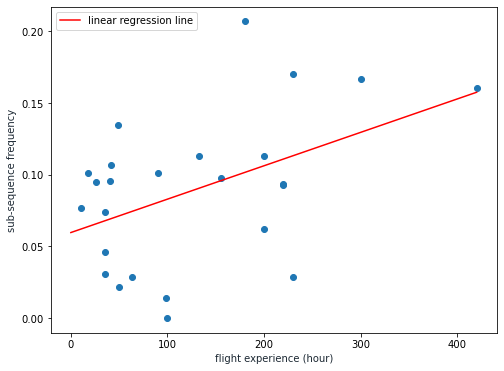

In [35]:
y = df_res["n_BXBX"].values
clf = LinearRegression().fit(X.reshape(-1,1), y)
f, ax = plt.subplots(figsize=(8, 6))

print(y)
print(X)

xx = np.linspace(0, max(X), 10)
yy = clf.intercept_ + clf.coef_[0]*xx

print(clf.coef_[0])

plt.xlabel('flight experience (hour)', color='#1C2833')
plt.ylabel("sub-sequence frequency", color='#1C2833')
# plt.title("linear regression for sub-sequence length = 4")

ax.scatter(X,y)
ax.plot(xx, yy, '-r', label='linear regression line')
plt.legend(loc='upper left')

In [36]:
pred = clf.predict(X.reshape(-1,1))
r2_score(y,pred)

0.21198337982661386

In [37]:
clf.score(X.reshape(-1,1),y)

0.21198337982661386

In [ ]:
xlim = 2
ylim = 2

xx, yy = np.mgrid[-xlim:xlim:.001, -ylim:ylim:.001]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
# print(xx.shape)
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[:,0], X[:, 1], c=y, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(-xlim, xlim), ylim=(-ylim, ylim),
       xlabel=col[0], ylabel=col[1])

In [ ]:
f, ax = plt.subplots(figsize=(8, 6))
ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)

ax.scatter(X[:,0], X[:, 1], c=y, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(-xlim, xlim), ylim=(-ylim, ylim),
       xlabel="$X_1$", ylabel="$X_2$")

In [ ]:
names = ["Logistic Regression","Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [ ]:
figure = plt.figure(figsize=(27, 9))
i = 1

h=0.01
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
print(xx.shape)
# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(1, len(classifiers) + 1, i)
ax.set_title("Input data")
# Plot the training points
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright,
           edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i += 1

# iterate over classifiers
for name, clf in zip(names, classifiers):
    ax = plt.subplot(1, len(classifiers) + 1, i)
    clf.fit(X, y)
    
    score = clf.score(X, y)
#         Plot the decision boundary. For that, we will assign a color to each
#     point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright,
               edgecolors='k')

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            size=15, horizontalalignment='right')
    i += 1